In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib as matplotlib

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import warnings
warnings.filterwarnings('ignore')
# 그래프를 그리기 위한 기본 설정 
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 14
# 폰트 설정 시 - 기호 깨지는 거 방지하기
plt.rcParams['axes.unicode_minus'] = False

# 1. 모델링
## 1) 데이터 불러오기

In [2]:
df = pd.read_csv('data/df_final.csv')

In [3]:
len(df)

9181

In [4]:
cat_columns = [c for c, t in zip(df.dtypes.index, df.dtypes) if t=='O'] 
num_columns = [c for c in df.columns if c not in cat_columns]

print(f'Categorical Columns: \n{cat_columns}\n')
print(f'Numeric Columns: \n{num_columns}\n')

Categorical Columns: 
['경매일', '화훼부류명', '품목명', '품종명', '등급명', '요일']

Numeric Columns: 
['최고가', '최저가', '평균가', '총금액', '총물량', '연도', '월', '일', '비수기여부']



### 1.1 시계열 데이터 변환

In [5]:
a = df.groupby(['품종명', '연도','월','일'])['총물량'].sum()
b = df.groupby(['품종명', '연도','월','일'])['총금액'].sum()
df_a = pd.DataFrame(a)
df_b = pd.DataFrame(b)

df_merge = pd.concat([df_a, df_b], axis=1)

In [6]:
idx = df_merge.index

In [7]:
df_merge['품종명'] = [idx[x][0] for x in range(0, len(df_merge))]
df_merge['연도'] = [idx[x][1] for x in range(0, len(df_merge))]
df_merge['월'] = [idx[x][2] for x in range(0, len(df_merge))]
df_merge['일'] = [idx[x][3] for x in range(0, len(df_merge))]

In [8]:
idx_df = list(range(0, len(df_merge)))

In [9]:
df_merge.index = idx_df

In [10]:
df_merge

,총물량,총금액,품종명,연도,월,일
0,112,1365260,빅토리아,2018,1,3
1,156,2071160,빅토리아,2018,1,5
2,91,1253000,빅토리아,2018,1,8
3,64,782480,빅토리아,2018,1,10
4,65,645920,빅토리아,2018,1,12
...,...,...,...,...,...,...
1577,1569,7433100,헤라,2021,6,21
1578,1233,6424630,헤라,2021,6,23
1579,1371,7701620,헤라,2021,6,25
1580,1873,8866840,헤라,2021,6,28


In [11]:
df_merge['경매일'] = ["{}-{:02d}-{:02d}".format(int(df_merge['연도'][x]), int(df_merge['월'][x]), int(df_merge['일'][x])) for x in range(0, len(df_merge))]

In [12]:
df_merge['평균가'] = df_merge['총금액'] / df_merge['총물량']

In [13]:
df_merge.sort_values('경매일', inplace=True)

In [14]:
df_merge.to_csv('data/merge_df.csv', encoding='utf-8-sig')

## 2) 시계열 분석 모델링
 - ARIMA 모델
 - LSTM 모델

### 2.1 빅토리아 품종

#### 2.1.1 ARIMA 모델

In [15]:
df_vic = df_merge[df_merge['품종명'] == '빅토리아']

In [16]:
df_vic['경매일'] = pd.to_datetime(df_vic['경매일'])

In [17]:
df_vic['연도'] = df_vic['경매일'].dt.year

In [18]:
train_vic = df_vic.query('연도 <= 2020')
valid_vic =df_vic.query('연도 >= 2021')

In [19]:
train_vic = train_vic[['경매일','평균가']]
train_vic.index = train_vic['경매일']
train_vic.set_index('경매일', inplace=True)

In [20]:
valid_vic = valid_vic[['경매일','평균가']]
valid_vic.index = valid_vic['경매일']
valid_vic.set_index('경매일', inplace=True)

In [23]:
len(train_vic)

449

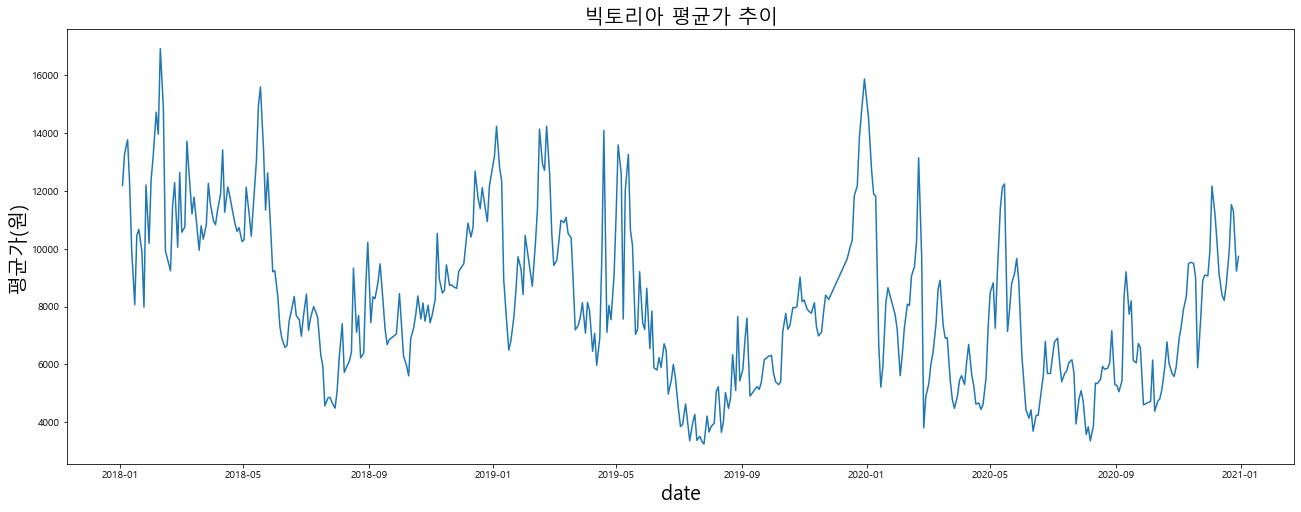

In [24]:
plt.figure(figsize=(22,8))
plt.plot(train_vic)
plt.title('빅토리아 평균가 추이', fontsize=20)
plt.xlabel("date", fontsize=20)
plt.ylabel('평균가(원)', fontsize=20)
plt.show()

##### ARIMA모형 p,d,r 최적의 파라메터값 찾기

In [149]:
# ARIMA_AIC_CHECK
def arima_aic_check(data, order,sort = 'AIC'):
    order_list = []
    aic_list = []
    bic_lsit = []
    for p in range(order[0]):
        for d in range(order[1]):
            for q in range(order[2]):
                model = ARIMA(data, order=(p,d,q))
                try:
                    model_fit = model.fit()
                    c_order = f'p:{p} d:{d} q:{q}'
                    aic = model_fit.aic
                    bic = model_fit.bic
                    order_list.append(c_order)
                    aic_list.append(aic)
                    bic_list.append(bic)
                except:
                    pass
    result_df = pd.DataFrame(list(zip(order_list, aic_list)),columns=['order','AIC'])
    result_df.sort_values(sort, inplace=True)
    return result_df

In [150]:
arima_aic_check( train_vic, [4,3,4] )

,order,AIC
29,p:2 d:2 q:2,7695.138259
41,p:3 d:2 q:2,7695.572118
17,p:1 d:1 q:1,7701.477047
18,p:1 d:1 q:2,7701.683187
25,p:2 d:1 q:1,7701.975068
36,p:3 d:1 q:1,7702.350685
26,p:2 d:1 q:2,7703.066797
38,p:3 d:1 q:3,7703.465172
11,p:0 d:2 q:3,7703.789084
37,p:3 d:1 q:2,7705.755304


##### TRAIN SET 모델 훈련시키기

In [151]:
# (AR=2, 차분=2, MA=2, 파라미터로 ARIMA 모델을 학습합니다.
model = ARIMA(train_vic, order=(2,2,2))

#trend : constant를 가지고 있는지, c - constant / nc - no constant
#disp : 수렴 정보를 나타냄
model_fit = model.fit(trend='c', full_output=True, disp=True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D2.평균가   No. Observations:                  447
Model:                 ARIMA(2, 2, 2)   Log Likelihood               -3841.569
Method:                       css-mle   S.D. of innovations           1293.976
Date:                Fri, 01 Oct 2021   AIC                           7695.138
Time:                        16:42:12   BIC                           7719.754
Sample:                             2   HQIC                          7704.843
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1611      0.164      0.985      0.324      -0.159       0.482
ar.L1.D2.평균가     0.7893      0.028     28.110      0.000       0.734       0.844
ar.L2.D2.평균가    -0.0651      0.043     -1.51

##### ARIMA 시각화

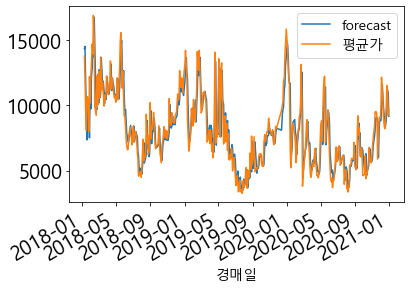

In [152]:
model_fit.plot_predict()
plt.show()

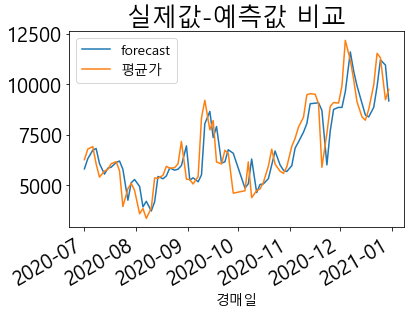

In [153]:
import datetime
model_fit.plot_predict(start=datetime.datetime(2020,7,1))
plt.title('실제값-예측값 비교', fontsize=25)
plt.show()

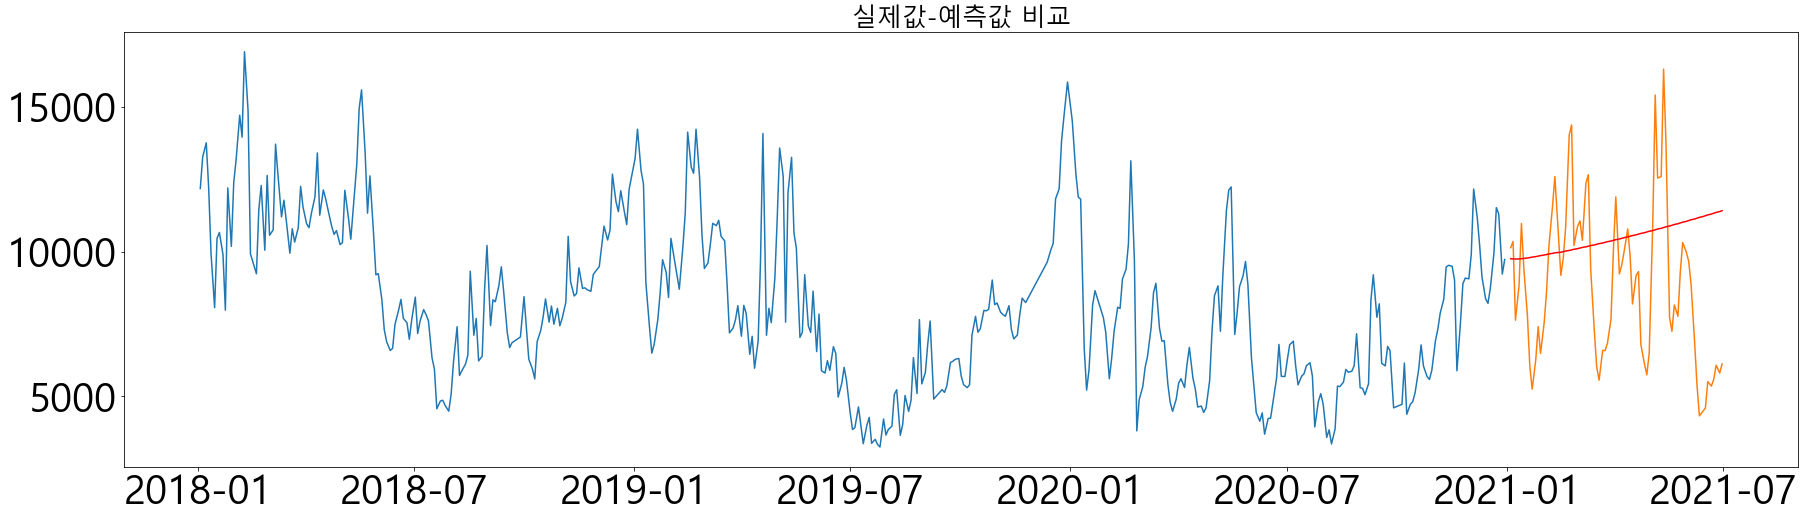

In [157]:
# valid로 예측해보기
full_forecast = model_fit.forecast(steps=valid_vic.shape[0])
forecast = pd.DataFrame(full_forecast[0], index=valid_vic.index, columns=valid_vic.columns)

plt.figure(figsize=(30,8))
plt.plot(train_vic)
plt.plot(valid_vic)
plt.rc('xtick', labelsize=40)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=40)  # y축 눈금 폰트 크기
plt.plot(forecast, 'r')
plt.title('실제값-예측값 비교', fontsize=25)
plt.show()

#### 2.1.2 LSTM 모델
- 참고 : https://roboreport.co.kr/%eb%94%a5%eb%9f%ac%eb%8b%9dlstm%ec%9c%bc%eb%a1%9c-%ec%95%84%ed%8c%8c%ed%8a%b8-%ec%a7%80%ec%88%98-%ec%98%88%ec%b8%a1%ed%95%98%ea%b8%b0-2-lstm-%ec%8b%a4%ed%97%98%ed%95%98%ea%b8%b0/#comment-261

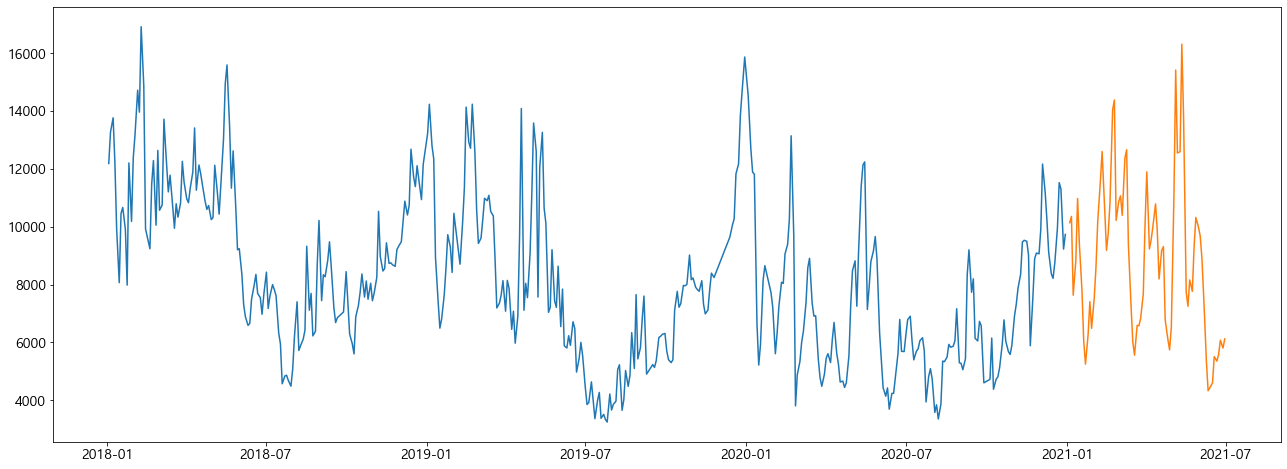

In [21]:
# train / validation 확인
plt.figure(figsize=(22,8))
plt.plot(train_vic)
plt.plot(valid_vic)
plt.rc('xtick', labelsize=10)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=10)  # y축 눈금 폰트 크기
plt.show()

<Figure size 1584x576 with 0 Axes>

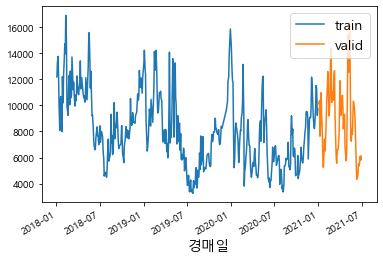

In [22]:
# train / validation 확인
plt.figure(figsize=(22,8))
plt.rc('xtick', labelsize=10)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=10)  # y축 눈금 폰트 크기
ax = train_vic.plot()
valid_vic.plot(ax=ax)
plt.legend(['train', 'valid'])

##### 데이터 스케일링(minmax)

In [23]:
sc = MinMaxScaler()

train_sc = sc.fit_transform(train_vic)
valid_sc = sc.transform(valid_vic)

len(train_sc)

449

In [24]:
train_sc_df = pd.DataFrame(train_sc, columns=['평균가'], index=train_vic.index)
valid_sc_df = pd.DataFrame(valid_sc, columns=['평균가'], index=valid_vic.index)
train_sc_df.head()

,평균가
경매일,
2018-01-03,0.654005
2018-01-05,0.733506
2018-01-08,0.769536
2018-01-10,0.656670
2018-01-12,0.489232


##### sliding window 구성하기
- window는 LSTM을 훈련하기 위한 단위로 고정된 사이즈를 가집니다. <br>window가 12개라면 과거 시간 데이터 12개를 사용해서 다음 시간 단위의 값을 예측하게 됩니다. <br>현재 실험 데이터의 경우 과거의 시간 단위 12개 부동산 지수들이 훈련 속성들이 되고 현재 시간의 부동산 지수가 target이 됩니다.<br>

In [25]:
for s in range(1, 4):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['평균가'].shift(s)
    valid_sc_df['shift_{}'.format(s)] = valid_sc_df['평균가'].shift(s)

train_sc_df.head(3)

,평균가,shift_1,shift_2,shift_3
경매일,,,,
2018-01-03,0.654005,NaN,NaN,NaN
2018-01-05,0.733506,0.654005,NaN,NaN
2018-01-08,0.769536,0.733506,0.654005,NaN


##### 데이터에서 빈 값 제거하기

In [26]:
X_train = train_sc_df.dropna().drop('평균가', axis=1)
y_train = train_sc_df.dropna()[['평균가']]

X_valid = valid_sc_df.dropna().drop('평균가', axis=1)
y_valid = valid_sc_df.dropna()[['평균가']]

X_train.head()

,shift_1,shift_2,shift_3
경매일,,,
2018-01-10,0.769536,0.733506,0.654005
2018-01-12,0.656670,0.769536,0.733506
2018-01-15,0.489232,0.656670,0.769536
2018-01-17,0.352576,0.489232,0.656670
2018-01-19,0.527625,0.352576,0.489232


In [28]:
X_valid_idx = X_valid.index

In [30]:
print(type(X_train))
X_train = X_train.values
print(type(X_train))
X_valid= X_valid.values
y_train = y_train.values
y_valid = y_valid.values

print(X_train.shape)
print(y_train.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
(446, 3)
(446, 1)


In [31]:
X_train_t = X_train.reshape(X_train.shape[0], 3, 1)
X_valid_t = X_valid.reshape(X_valid.shape[0], 3, 1)

print("최종 DATA")
print(X_train_t.shape)
print(X_train_t)
print(y_train)

최종 DATA
(446, 3, 1)
[[[0.7695361 ]
  [0.73350585]
  [0.65400491]]

 [[0.6566696 ]
  [0.7695361 ]
  [0.73350585]]

 [[0.48923161]
  [0.6566696 ]
  [0.7695361 ]]

 ...

 [[0.60555085]
  [0.4912298 ]
  [0.40249019]]

 [[0.5893863 ]
  [0.60555085]
  [0.4912298 ]]

 [[0.43746928]
  [0.5893863 ]
  [0.60555085]]]
[[0.6566696 ]
 [0.48923161]
 [0.35257624]
 [0.52762531]
 [0.54277048]
 [0.48658824]
 [0.34626543]
 [0.65534027]
 [0.50756944]
 [0.66876127]
 [0.72710839]
 [0.83938649]
 [0.78386152]
 [1.        ]
 [0.85005156]
 [0.4883668 ]
 [0.43828626]
 [0.60120486]
 [0.66141886]
 [0.49786893]
 [0.68703098]
 [0.53569479]
 [0.54904137]
 [0.7661501 ]
 [0.68923975]
 [0.58205017]
 [0.62434518]
 [0.57233133]
 [0.49026518]
 [0.5521445 ]
 [0.51824797]
 [0.55450394]
 [0.65946021]
 [0.60689721]
 [0.56485398]
 [0.55473432]
 [0.59119351]
 [0.63285307]
 [0.74389024]
 [0.58638622]
 [0.65014588]
 [0.62754741]
 [0.59902971]
 [0.55830989]
 [0.53794444]
 [0.54759727]
 [0.51211588]
 [0.51694555]
 [0.64944466]
 [0.58

##### LSTM 모델 생성하기
- 전체 모델은 다음과 같은 2개의 레이어로 구성되었습니다.<br>
  20 메모리 셀을 가진 LSTM 레이어 하나<br>
  Dense 레이어 하나 (output)<br>

In [32]:
from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping

K.clear_session()
    
model = Sequential() # Sequeatial Model 
model.add(LSTM(20, input_shape=(12, 1))) # (timestep, feature) 
model.add(Dense(1)) # output = 1 
model.compile(loss='mean_squared_error', optimizer='adam') 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                1760      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


##### 모델 훈련하기
* epochs : 훈련은 에포크(epoch)로 구성됩니다. 한 에포크는 전체 입력 데이터를 한번 순회하는 것입니다(작은 배치로 나누어 수행됩니다).
* batch_size : numpy 데이터를 전달하면 모델은 데이터를 작은 배치로 나누고 훈련 과정에서 이 배치를 순회합니다. 이 정수 값은 배치의 크기를 지정합니다. 전체 샘플 개수가 배치 크기로 나누어 떨어지지 않으면 마지막 배치의 크기는 더 작을 수 있습니다.
* validation_data(x_val, y_val) = 검증 데이터(validation data)를 사용합니다. 검증 데이터를 사용하면 각 에포크마다 검증 데이터의 정확도도 함께 출력되는데, 이 정확도는 훈련이 잘 되고 있는지를 보여줄 뿐이며 실제로 모델이 검증 데이터를 학습하지는 않습니다. 검증 데이터의 loss가 낮아지다가 높아지기 시작하면 이는 과적합(overfitting)의 신호입니다.
* validation_split : validation_data 대신 사용할 수 있습니다. 검증 데이터를 사용하는 것은 동일하지만, 별도로 존재하는 검증 데이터를 주는 것이 아니라 X_train과 y_train에서 일정 비율을 분리하여 이를 검증 데이터로 사용합니다. 역시나 훈련 자체에는 반영되지 않고 훈련 과정을 지켜보기 위한 용도로 사용됩니다. 사용 예시 : validation_split=0.2
* verbose : 훈련의 진행과정을 보여줍니다. 0일 경우 아무것도 출력하지 않고, 1일 경우 훈련의 진행도를 보여주는 진행 막대를 보여줍니다. 2일 경우 미니 배치마다 손실 정보를 출력합니다.

In [33]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

model.fit(X_train_t, y_train, epochs=100,
          batch_size=20, verbose=1, callbacks=[early_stop])

Epoch 1/100
23/23 [==============================] - 1s 1ms/step - loss: 0.1396
Epoch 2/100
23/23 [==============================] - 0s 1ms/step - loss: 0.0603
Epoch 3/100
23/23 [==============================] - 0s 1ms/step - loss: 0.0256
Epoch 4/100
23/23 [==============================] - 0s 1ms/step - loss: 0.0207
Epoch 5/100
23/23 [==============================] - 0s 1ms/step - loss: 0.0189
Epoch 6/100
23/23 [==============================] - 0s 1ms/step - loss: 0.0174
Epoch 7/100
23/23 [==============================] - 0s 1ms/step - loss: 0.0160
Epoch 8/100
23/23 [==============================] - 0s 1ms/step - loss: 0.0148
Epoch 9/100
23/23 [==============================] - 0s 1ms/step - loss: 0.0139
Epoch 10/100
23/23 [==============================] - 0s 1ms/step - loss: 0.0130
Epoch 11/100
23/23 [==============================] - 0s 1ms/step - loss: 0.0126
Epoch 12/100
23/23 [==============================] - 0s 1ms/step - loss: 0.0122
Epoch 13/100
23/23 [=================

Text(0.5, 1.0, '평균가 vs Predicted 평균가 Index: $Y_i$ vs $\\hat{Y}_i$')

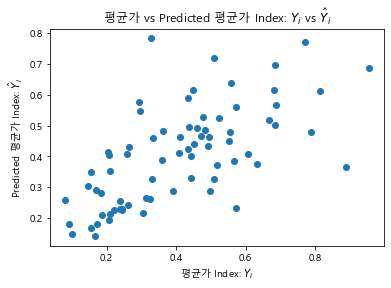

In [34]:
#원래 값과 예측 값이 일치하면 직선에 가깝게 분포가 되는데 결과는 그리 만족스럽지 않은 것 같습니다. 

%matplotlib inline

y_pred = model.predict(X_valid_t, batch_size=32)
plt.scatter(y_valid, y_pred)
plt.rc('xtick', labelsize=5)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=5)  # y축 눈금 폰트 크기
plt.xlabel("평균가 Index: $Y_i$")
plt.ylabel("Predicted 평균가 Index: $\hat{Y}_i$")
plt.title("평균가 vs Predicted 평균가 Index: $Y_i$ vs $\hat{Y}_i$")

In [43]:
y_valid

array([[0.40857418],
       [0.56542376],
       [0.45238393],
       [0.33278902],
       [0.20522351],
       [0.14649889],
       [0.22075885],
       [0.30442578],
       [0.23700494],
       [0.31309143],
       [0.39151416],
       [0.50774784],
       [0.60794479],
       [0.6842803 ],
       [0.43426803],
       [0.47799821],
       [0.55532474],
       [0.78934996],
       [0.81457824],
       [0.50998045],
       [0.55836611],
       [0.57198004],
       [0.52287262],
       [0.667305  ],
       [0.68882373],
       [0.4489943 ],
       [0.29561845],
       [0.20276726],
       [0.16910089],
       [0.24448831],
       [0.24362675],
       [0.26223685],
       [0.32421003],
       [0.49823186],
       [0.63273823],
       [0.43778544],
       [0.46100131],
       [0.49488782],
       [0.5517317 ],
       [0.48290549],
       [0.36185466],
       [0.43411831],
       [0.44369317],
       [0.25872811],
       [0.21032697],
       [0.18254808],
       [0.23897478],
       [0.572

In [39]:
y_valid_shift = np.roll(y_valid, 1)
y_valid_shift[0] = None

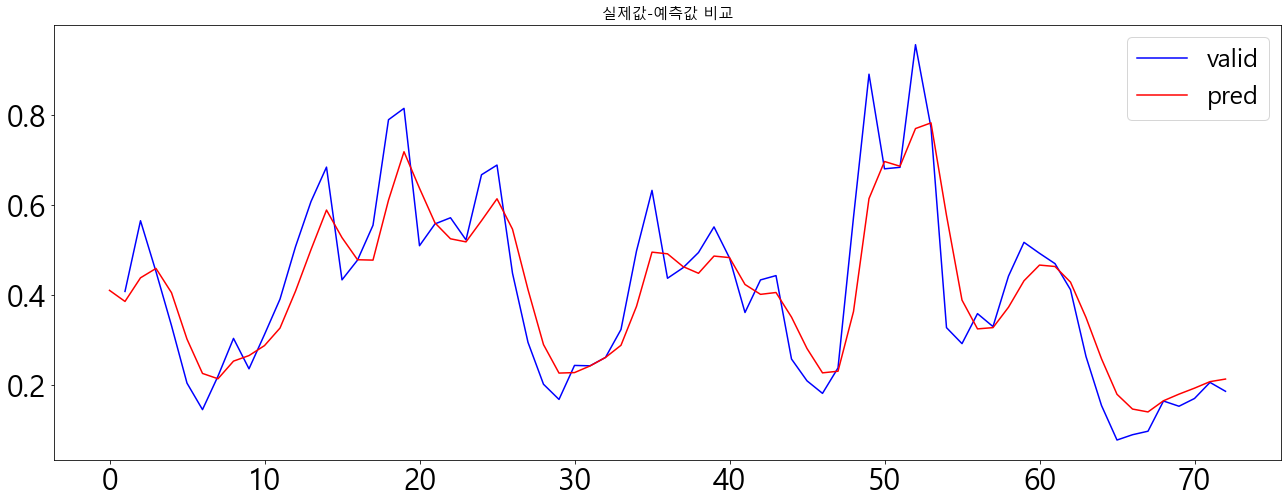

In [56]:
plt.figure(figsize=(22,8))
plt.plot(y_valid_shift, 'b')
plt.plot(y_pred, 'r')
plt.rc('xtick', labelsize=30)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=30)  # y축 눈금 폰트 크기
plt.legend(['valid', 'pred'], fontsize=25)
plt.title('실제값-예측값 비교', fontsize=15)
plt.show()

### 2.2 푸에고 품종

#### 2.2.1 ARIMA 모델

In [58]:
df_pue = df_merge[df_merge['품종명'] == '푸에고']

In [59]:
df_pue['경매일'] = pd.to_datetime(df_pue['경매일'])

In [60]:
df_pue['연도'] = df_pue['경매일'].dt.year

In [61]:
train_pue = df_pue.query('연도 <= 2020')
valid_pue =df_pue.query('연도 >= 2021')

In [62]:
train_pue = train_pue[['경매일','평균가']]
train_pue.index = train_pue['경매일']
train_pue.set_index('경매일', inplace=True)

In [63]:
valid_pue = valid_pue[['경매일','평균가']]
valid_pue.index = valid_pue['경매일']
valid_pue.set_index('경매일', inplace=True)

In [64]:
len(train_pue)

456

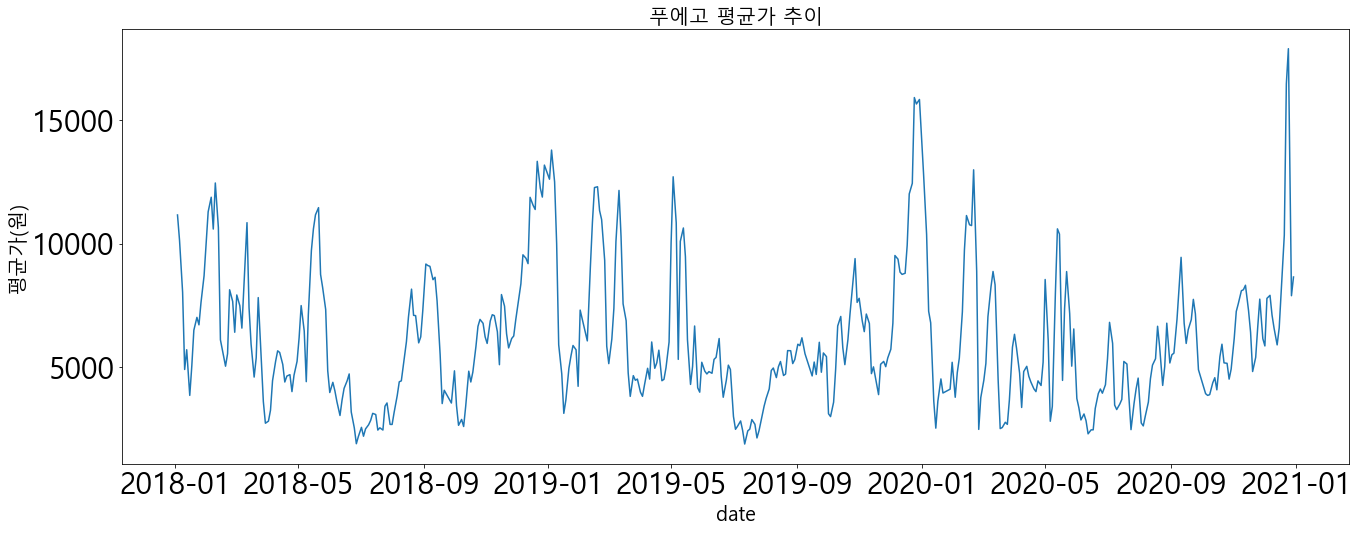

In [65]:
plt.figure(figsize=(22,8))
plt.plot(train_pue)
plt.title('푸에고 평균가 추이', fontsize=20)
plt.xlabel("date", fontsize=20)
plt.ylabel('평균가(원)', fontsize=20)
plt.show()

##### ARIMA모형 p,d,r 최적의 파라메터값 찾기

In [66]:
# ARIMA_AIC_CHECK
def arima_aic_check(data, order,sort = 'AIC'):
    order_list = []
    aic_list = []
    bic_lsit = []
    for p in range(order[0]):
        for d in range(order[1]):
            for q in range(order[2]):
                model = ARIMA(data, order=(p,d,q))
                try:
                    model_fit = model.fit()
                    c_order = f'p:{p} d:{d} q:{q}'
                    aic = model_fit.aic
                    bic = model_fit.bic
                    order_list.append(c_order)
                    aic_list.append(aic)
                    bic_list.append(bic)
                except:
                    pass
    result_df = pd.DataFrame(list(zip(order_list, aic_list)),columns=['order','AIC'])
    result_df.sort_values(sort, inplace=True)
    return result_df

In [67]:
arima_aic_check( train_pue, [4,3,4] )

,order,AIC
42,p:3 d:1 q:3,7895.256687
45,p:3 d:2 q:2,7897.356963
30,p:2 d:1 q:3,7898.629735
18,p:1 d:1 q:2,7898.820162
19,p:1 d:1 q:3,7900.116425
29,p:2 d:1 q:2,7900.328674
33,p:2 d:2 q:2,7902.033349
46,p:3 d:2 q:3,7905.023918
28,p:2 d:1 q:1,7905.155591
37,p:3 d:0 q:2,7907.186796


##### TRAIN SET 모델 훈련시키기

In [68]:
# (AR=3, 차분=1, MA=3, 파라미터로 ARIMA 모델을 학습합니다.
model = ARIMA(train_pue, order=(3,1,3))

#trend : constant를 가지고 있는지, c - constant / nc - no constant
#disp : 수렴 정보를 나타냄
model_fit = model.fit(trend='c', full_output=True, disp=True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                  D.평균가   No. Observations:                  455
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -3939.628
Method:                       css-mle   S.D. of innovations           1387.212
Date:                Mon, 04 Oct 2021   AIC                           7895.257
Time:                        11:01:51   BIC                           7928.219
Sample:                             1   HQIC                          7908.242
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.9608      3.025     -0.318      0.751      -6.891       4.969
ar.L1.D.평균가    -0.4353      0.120     -3.619      0.000      -0.671      -0.200
ar.L2.D.평균가     0.6638      0.059     11.206    

##### ARIMA 시각화

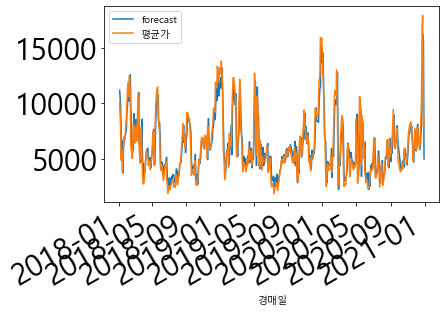

<Figure size 1584x576 with 0 Axes>

In [69]:
model_fit.plot_predict()
plt.figure(figsize=(22,8))
plt.show()

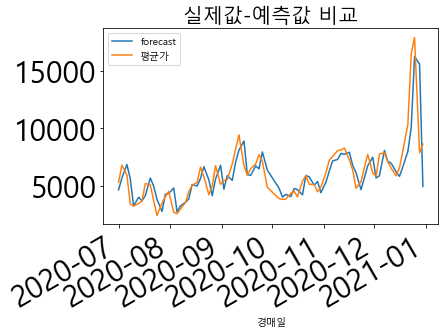

In [70]:
import datetime
model_fit.plot_predict(start=datetime.datetime(2020,7,1))
plt.title('실제값-예측값 비교', fontsize=20)
plt.show()

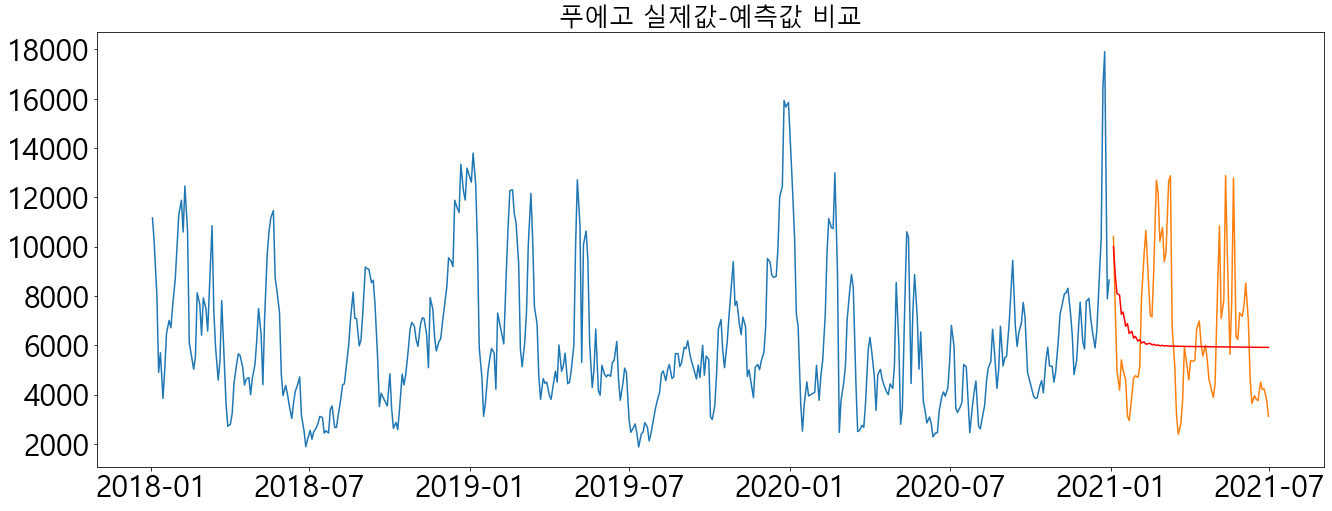

In [71]:
# valid로 예측해보기
full_forecast = model_fit.forecast(steps=valid_pue.shape[0])
forecast = pd.DataFrame(full_forecast[0], index=valid_pue.index, columns=valid_pue.columns)

plt.figure(figsize=(22,8))
plt.plot(train_pue)
plt.plot(valid_pue)
plt.rc('xtick', labelsize=20)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.plot(forecast, 'r')
plt.title('푸에고 실제값-예측값 비교', fontsize=25)
plt.show()

#### 2.2.2 LSTM 모델
- 참고 : https://roboreport.co.kr/%eb%94%a5%eb%9f%ac%eb%8b%9dlstm%ec%9c%bc%eb%a1%9c-%ec%95%84%ed%8c%8c%ed%8a%b8-%ec%a7%80%ec%88%98-%ec%98%88%ec%b8%a1%ed%95%98%ea%b8%b0-2-lstm-%ec%8b%a4%ed%97%98%ed%95%98%ea%b8%b0/#comment-261

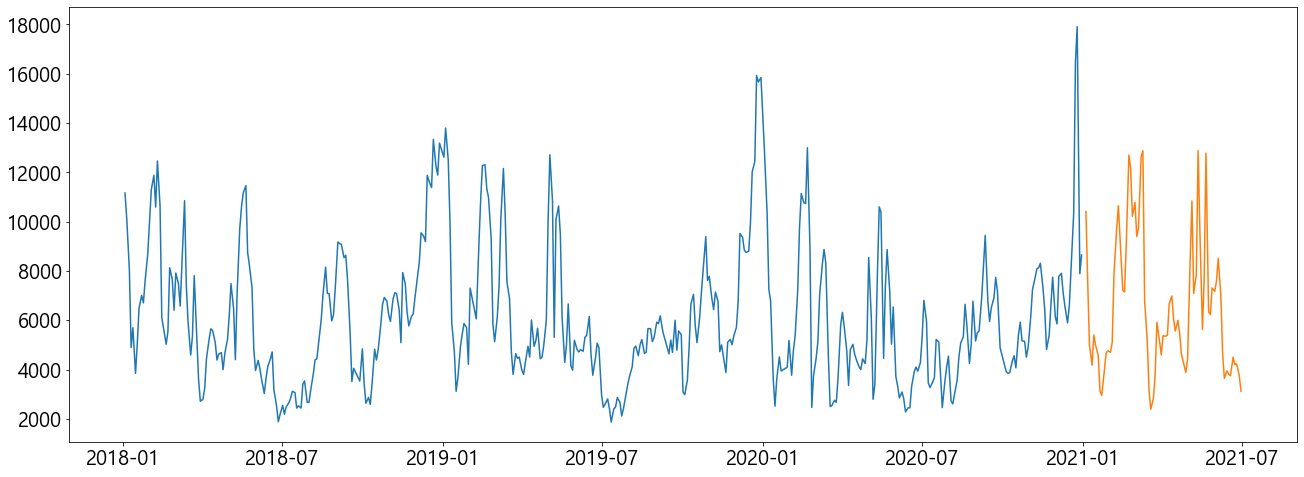

In [72]:
# train / validation 확인
plt.figure(figsize=(22,8))
plt.plot(train_pue)
plt.plot(valid_pue)
plt.rc('xtick', labelsize=10)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=10)  # y축 눈금 폰트 크기
plt.show()

<Figure size 1584x576 with 0 Axes>

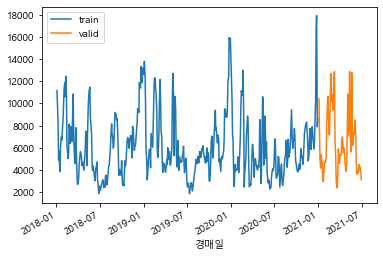

In [73]:
# train / validation 확인
plt.figure(figsize=(22,8))
plt.rc('xtick', labelsize=10)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=10)  # y축 눈금 폰트 크기
ax = train_pue.plot()
valid_pue.plot(ax=ax)
plt.legend(['train', 'valid'])

##### 데이터 스케일링(minmax)

In [74]:
sc = MinMaxScaler()

train_sc = sc.fit_transform(train_pue)
valid_sc = sc.transform(valid_pue)

len(train_sc)

456

In [75]:
train_sc_df = pd.DataFrame(train_sc, columns=['평균가'], index=train_pue.index)
valid_sc_df = pd.DataFrame(valid_sc, columns=['평균가'], index=valid_pue.index)
train_sc_df.head()

,평균가
경매일,
2018-01-03,0.579400
2018-01-05,0.514945
2018-01-08,0.384047
2018-01-10,0.188584
2018-01-12,0.238529


##### sliding window 구성하기
- window는 LSTM을 훈련하기 위한 단위로 고정된 사이즈를 가집니다. <br>window가 12개라면 과거 시간 데이터 12개를 사용해서 다음 시간 단위의 값을 예측하게 됩니다. <br>현재 실험 데이터의 경우 과거의 시간 단위 12개 부동산 지수들이 훈련 속성들이 되고 현재 시간의 부동산 지수가 target이 됩니다.<br>

In [76]:
for s in range(1, 4):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['평균가'].shift(s)
    valid_sc_df['shift_{}'.format(s)] = valid_sc_df['평균가'].shift(s)

train_sc_df.head(3)

,평균가,shift_1,shift_2,shift_3
경매일,,,,
2018-01-03,0.579400,NaN,NaN,NaN
2018-01-05,0.514945,0.579400,NaN,NaN
2018-01-08,0.384047,0.514945,0.5794,NaN


##### 데이터에서 빈 값 제거하기

In [77]:
X_train = train_sc_df.dropna().drop('평균가', axis=1)
y_train = train_sc_df.dropna()[['평균가']]

X_valid = valid_sc_df.dropna().drop('평균가', axis=1)
y_valid = valid_sc_df.dropna()[['평균가']]

X_train.head()

,shift_1,shift_2,shift_3
경매일,,,
2018-01-10,0.384047,0.514945,0.579400
2018-01-12,0.188584,0.384047,0.514945
2018-01-15,0.238529,0.188584,0.384047
2018-01-17,0.123023,0.238529,0.188584
2018-01-19,0.197585,0.123023,0.238529


In [78]:
print(type(X_train))
X_train = X_train.values
print(type(X_train))
X_valid= X_valid.values
y_train = y_train.values
y_valid = y_valid.values

print(X_train.shape)
print(y_train.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
(453, 3)
(453, 1)


In [79]:
X_train_t = X_train.reshape(X_train.shape[0], 3, 1)
X_valid_t = X_valid.reshape(X_valid.shape[0], 3, 1)

print("최종 DATA")
print(X_train_t.shape)
print(X_train_t)
print(y_train)

최종 DATA
(453, 3, 1)
[[[0.38404686]
  [0.51494514]
  [0.5793997 ]]

 [[0.18858433]
  [0.38404686]
  [0.51494514]]

 [[0.23852915]
  [0.18858433]
  [0.38404686]]

 ...

 [[0.91083658]
  [0.52844904]
  [0.386113  ]]

 [[1.        ]
  [0.91083658]
  [0.52844904]]

 [[0.37517939]
  [1.        ]
  [0.91083658]]]
[[1.88584333e-01]
 [2.38529151e-01]
 [1.23022524e-01]
 [1.97584813e-01]
 [2.87965984e-01]
 [3.20387583e-01]
 [3.01490963e-01]
 [3.58077432e-01]
 [4.25657588e-01]
 [5.08340982e-01]
 [5.87441251e-01]
 [6.24275214e-01]
 [5.43814219e-01]
 [6.60310709e-01]
 [5.47459099e-01]
 [2.63568611e-01]
 [1.96866699e-01]
 [2.28649909e-01]
 [3.90234725e-01]
 [3.60606118e-01]
 [2.82738396e-01]
 [3.77026920e-01]
 [3.49830422e-01]
 [2.93215339e-01]
 [4.02264088e-01]
 [5.59945799e-01]
 [3.45039902e-01]
 [2.52565158e-01]
 [1.69398045e-01]
 [2.17897810e-01]
 [3.70402875e-01]
 [2.12716959e-01]
 [1.07358208e-01]
 [5.26190747e-02]
 [5.79458673e-02]
 [8.56512339e-02]
 [1.60221087e-01]
 [2.09187808e-01]
 [2.3577

##### LSTM 모델 생성하기
- 전체 모델은 다음과 같은 2개의 레이어로 구성되었습니다.<br>
  20 메모리 셀을 가진 LSTM 레이어 하나<br>
  Dense 레이어 하나 (output)<br>

In [80]:
from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping

K.clear_session()
    
model = Sequential() # Sequeatial Model 
model.add(LSTM(20, input_shape=(12, 1))) # (timestep, feature) 
model.add(Dense(1)) # output = 1 
model.compile(loss='mean_squared_error', optimizer='adam') 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                1760      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


##### 모델 훈련하기
* epochs : 훈련은 에포크(epoch)로 구성됩니다. 한 에포크는 전체 입력 데이터를 한번 순회하는 것입니다(작은 배치로 나누어 수행됩니다).
* batch_size : numpy 데이터를 전달하면 모델은 데이터를 작은 배치로 나누고 훈련 과정에서 이 배치를 순회합니다. 이 정수 값은 배치의 크기를 지정합니다. 전체 샘플 개수가 배치 크기로 나누어 떨어지지 않으면 마지막 배치의 크기는 더 작을 수 있습니다.
* validation_data(x_val, y_val) = 검증 데이터(validation data)를 사용합니다. 검증 데이터를 사용하면 각 에포크마다 검증 데이터의 정확도도 함께 출력되는데, 이 정확도는 훈련이 잘 되고 있는지를 보여줄 뿐이며 실제로 모델이 검증 데이터를 학습하지는 않습니다. 검증 데이터의 loss가 낮아지다가 높아지기 시작하면 이는 과적합(overfitting)의 신호입니다.
* validation_split : validation_data 대신 사용할 수 있습니다. 검증 데이터를 사용하는 것은 동일하지만, 별도로 존재하는 검증 데이터를 주는 것이 아니라 X_train과 y_train에서 일정 비율을 분리하여 이를 검증 데이터로 사용합니다. 역시나 훈련 자체에는 반영되지 않고 훈련 과정을 지켜보기 위한 용도로 사용됩니다. 사용 예시 : validation_split=0.2
* verbose : 훈련의 진행과정을 보여줍니다. 0일 경우 아무것도 출력하지 않고, 1일 경우 훈련의 진행도를 보여주는 진행 막대를 보여줍니다. 2일 경우 미니 배치마다 손실 정보를 출력합니다.

In [81]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

model.fit(X_train_t, y_train, epochs=100,
          batch_size=20, verbose=1, callbacks=[early_stop])

Epoch 1/100
23/23 [==============================] - 1s 2ms/step - loss: 0.0955
Epoch 2/100
23/23 [==============================] - 0s 1ms/step - loss: 0.0501
Epoch 3/100
23/23 [==============================] - 0s 1ms/step - loss: 0.0271
Epoch 4/100
23/23 [==============================] - 0s 1ms/step - loss: 0.0217
Epoch 5/100
23/23 [==============================] - 0s 1ms/step - loss: 0.0201
Epoch 6/100
23/23 [==============================] - 0s 1ms/step - loss: 0.0186
Epoch 7/100
23/23 [==============================] - 0s 1ms/step - loss: 0.0171
Epoch 8/100
23/23 [==============================] - 0s 1ms/step - loss: 0.0158
Epoch 9/100
23/23 [==============================] - 0s 1ms/step - loss: 0.0146
Epoch 10/100
23/23 [==============================] - 0s 1ms/step - loss: 0.0139
Epoch 11/100
23/23 [==============================] - 0s 1ms/step - loss: 0.0131
Epoch 12/100
23/23 [==============================] - 0s 1ms/step - loss: 0.0126
Epoch 13/100
23/23 [=================

Text(0.5, 1.0, '평균가 vs Predicted 평균가 Index: $Y_i$ vs $\\hat{Y}_i$')

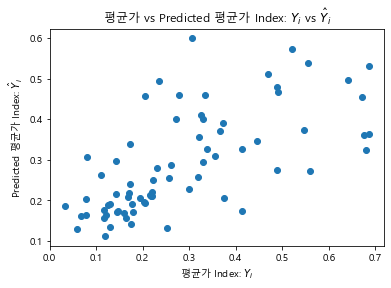

In [82]:
#원래 값과 예측 값이 일치하면 직선에 가깝게 분포가 되는데 결과는 그리 만족스럽지 않은 것 같습니다. 

%matplotlib inline

y_pred = model.predict(X_valid_t, batch_size=32)
plt.scatter(y_valid, y_pred)
plt.rc('xtick', labelsize=5)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=5)  # y축 눈금 폰트 크기
plt.xlabel("평균가 Index: $Y_i$")
plt.ylabel("Predicted 평균가 Index: $\hat{Y}_i$")
plt.title("평균가 vs Predicted 평균가 Index: $Y_i$ vs $\hat{Y}_i$")

In [83]:
y_valid_shift = np.roll(y_valid, 1)
y_valid_shift[0] = None

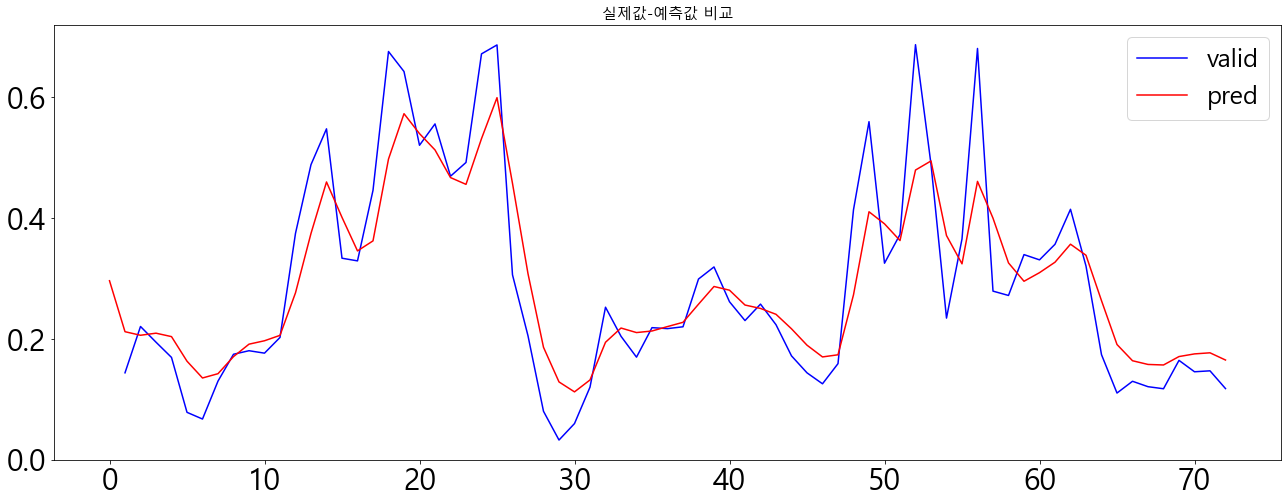

In [85]:
plt.figure(figsize=(22,8))
plt.plot(y_valid_shift, 'b')
plt.plot(y_pred, 'r')
plt.rc('xtick', labelsize=30)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=30)  # y축 눈금 폰트 크기
plt.legend(['valid', 'pred'], fontsize=25)
plt.title('실제값-예측값 비교', fontsize=15)
plt.show()

### 2.3 헤라 품종

#### 2.3.1 ARIMA 모델

In [86]:
df_hera = df_merge[df_merge['품종명'] == '헤라']

In [87]:
df_hera['경매일'] = pd.to_datetime(df_hera['경매일'])

In [88]:
df_hera['연도'] = df_hera['경매일'].dt.year

In [89]:
train_hera = df_hera.query('연도 <= 2020')
valid_hera =df_hera.query('연도 >= 2021')

In [90]:
train_hera = train_hera[['경매일','평균가']]
train_hera.index = train_hera['경매일']
train_hera.set_index('경매일', inplace=True)

In [91]:
valid_hera = valid_hera[['경매일','평균가']]
valid_hera.index = valid_hera['경매일']
valid_hera.set_index('경매일', inplace=True)

In [92]:
len(train_hera)

449

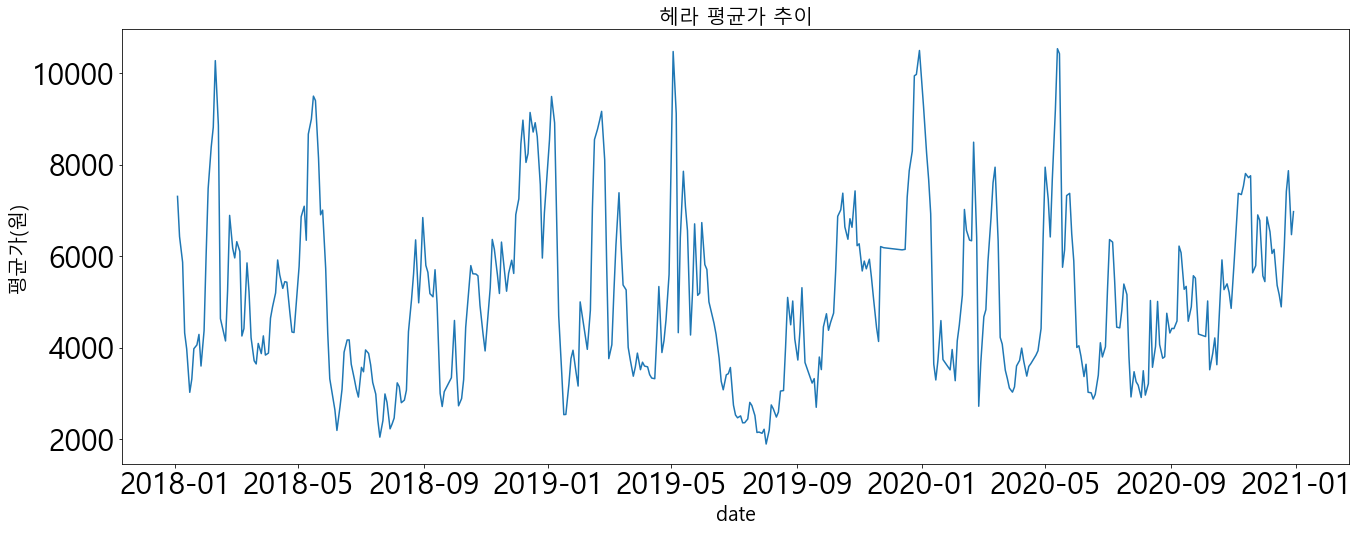

In [93]:
plt.figure(figsize=(22,8))
plt.plot(train_hera)
plt.title('헤라 평균가 추이', fontsize=20)
plt.xlabel("date", fontsize=20)
plt.ylabel('평균가(원)', fontsize=20)
plt.show()

##### ARIMA모형 p,d,r 최적의 파라메터값 찾기

In [94]:
# ARIMA_AIC_CHECK
def arima_aic_check(data, order,sort = 'AIC'):
    order_list = []
    aic_list = []
    bic_lsit = []
    for p in range(order[0]):
        for d in range(order[1]):
            for q in range(order[2]):
                model = ARIMA(data, order=(p,d,q))
                try:
                    model_fit = model.fit()
                    c_order = f'p:{p} d:{d} q:{q}'
                    aic = model_fit.aic
                    bic = model_fit.bic
                    order_list.append(c_order)
                    aic_list.append(aic)
                    bic_list.append(bic)
                except:
                    pass
    result_df = pd.DataFrame(list(zip(order_list, aic_list)),columns=['order','AIC'])
    result_df.sort_values(sort, inplace=True)
    return result_df

In [95]:
arima_aic_check( train_hera, [4,3,4] )

,order,AIC
46,p:3 d:2 q:3,7344.496723
30,p:2 d:1 q:2,7344.725544
19,p:1 d:1 q:3,7345.187986
23,p:1 d:2 q:3,7345.723184
31,p:2 d:1 q:3,7346.693123
41,p:3 d:1 q:2,7346.707157
18,p:1 d:1 q:2,7347.584879
42,p:3 d:1 q:3,7348.570079
25,p:2 d:0 q:1,7355.962666
14,p:1 d:0 q:2,7356.469562


##### TRAIN SET 모델 훈련시키기

In [96]:
# (AR=3, 차분=2, MA=3, 파라미터로 ARIMA 모델을 학습합니다.
model = ARIMA(train_hera, order=(3,2,3))

#trend : constant를 가지고 있는지, c - constant / nc - no constant
#disp : 수렴 정보를 나타냄
model_fit = model.fit(trend='c', full_output=True, disp=True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D2.평균가   No. Observations:                  447
Model:                 ARIMA(3, 2, 3)   Log Likelihood               -3664.248
Method:                       css-mle   S.D. of innovations            863.540
Date:                Mon, 04 Oct 2021   AIC                           7344.497
Time:                        11:03:20   BIC                           7377.317
Sample:                             2   HQIC                          7357.436
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0332      0.041      0.810      0.418      -0.047       0.114
ar.L1.D2.평균가     0.4901      0.048     10.296      0.000       0.397       0.583
ar.L2.D2.평균가     0.2922      0.051      5.72

##### ARIMA 시각화

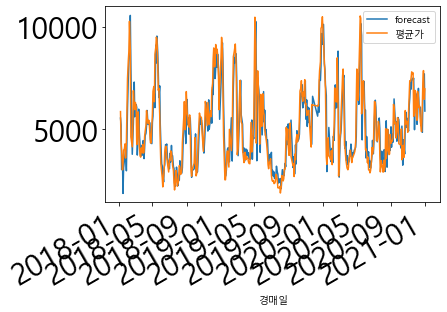

<Figure size 1584x576 with 0 Axes>

In [97]:
model_fit.plot_predict()
plt.figure(figsize=(22,8))
plt.show()

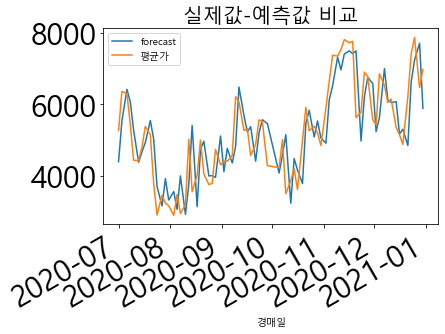

In [98]:
import datetime
model_fit.plot_predict(start=datetime.datetime(2020,7,1))
plt.title('실제값-예측값 비교', fontsize=20)
plt.show()

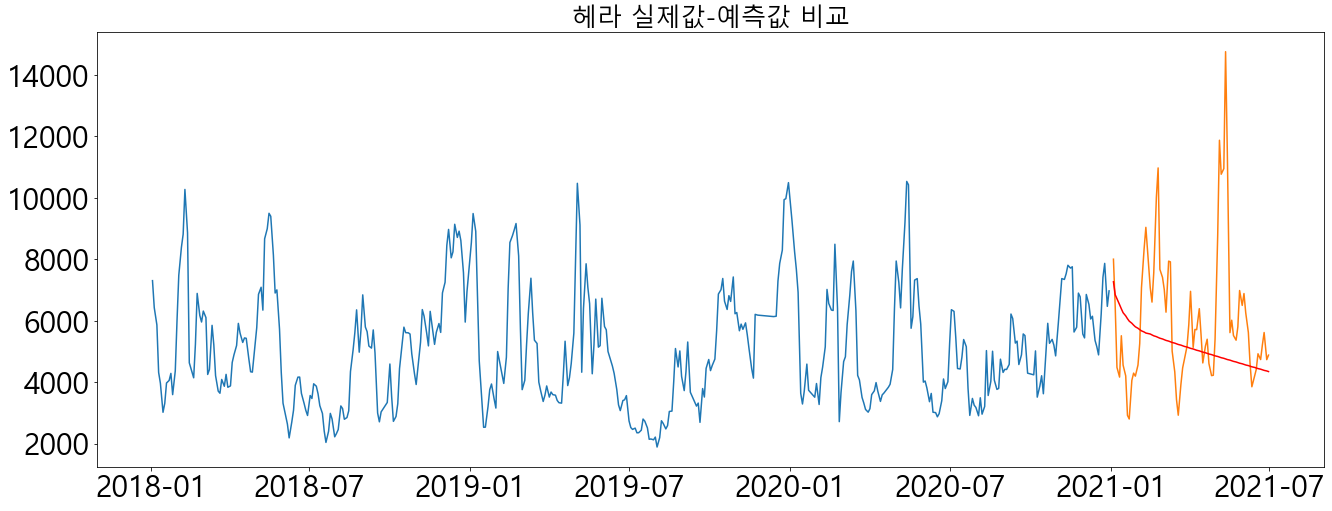

In [99]:
# valid로 예측해보기
full_forecast = model_fit.forecast(steps=valid_hera.shape[0])
forecast = pd.DataFrame(full_forecast[0], index=valid_hera.index, columns=valid_hera.columns)

plt.figure(figsize=(22,8))
plt.plot(train_hera)
plt.plot(valid_hera)
plt.rc('xtick', labelsize=20)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.plot(forecast, 'r')
plt.title('헤라 실제값-예측값 비교', fontsize=25)
plt.show()

#### 2.3.2 LSTM 모델
- 참고 : https://roboreport.co.kr/%eb%94%a5%eb%9f%ac%eb%8b%9dlstm%ec%9c%bc%eb%a1%9c-%ec%95%84%ed%8c%8c%ed%8a%b8-%ec%a7%80%ec%88%98-%ec%98%88%ec%b8%a1%ed%95%98%ea%b8%b0-2-lstm-%ec%8b%a4%ed%97%98%ed%95%98%ea%b8%b0/#comment-261

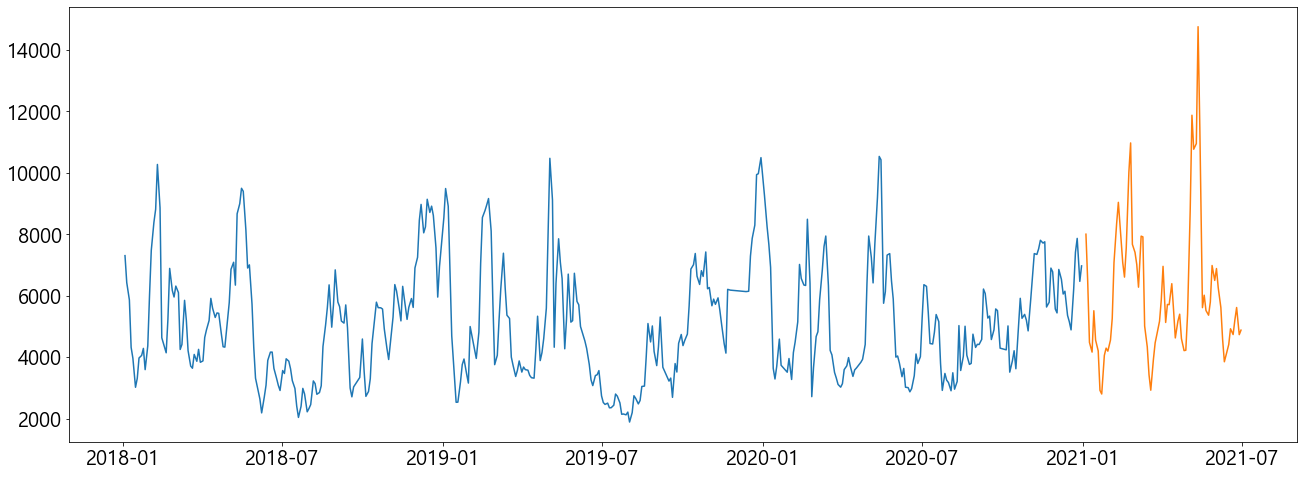

In [100]:
# train / validation 확인
plt.figure(figsize=(22,8))
plt.plot(train_hera)
plt.plot(valid_hera)
plt.rc('xtick', labelsize=10)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=10)  # y축 눈금 폰트 크기
plt.show()

<Figure size 1584x576 with 0 Axes>

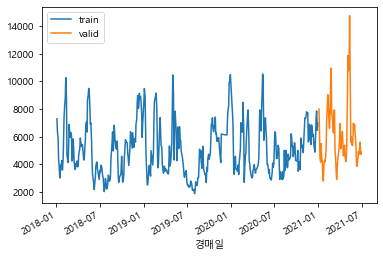

In [101]:
# train / validation 확인
plt.figure(figsize=(22,8))
plt.rc('xtick', labelsize=10)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=10)  # y축 눈금 폰트 크기
ax = train_hera.plot()
valid_hera.plot(ax=ax)
plt.legend(['train', 'valid'])

##### 데이터 스케일링(minmax)

In [102]:
sc = MinMaxScaler()

train_sc = sc.fit_transform(train_hera)
valid_sc = sc.transform(valid_hera)

len(train_sc)

449

In [103]:
train_sc_df = pd.DataFrame(train_sc, columns=['평균가'], index=train_hera.index)
valid_sc_df = pd.DataFrame(valid_sc, columns=['평균가'], index=valid_hera.index)
train_sc_df.head()

,평균가
경매일,
2018-01-03,0.626434
2018-01-05,0.524807
2018-01-08,0.459843
2018-01-10,0.280990
2018-01-12,0.240262


##### sliding window 구성하기
- window는 LSTM을 훈련하기 위한 단위로 고정된 사이즈를 가집니다. <br>window가 12개라면 과거 시간 데이터 12개를 사용해서 다음 시간 단위의 값을 예측하게 됩니다. <br>현재 실험 데이터의 경우 과거의 시간 단위 12개 부동산 지수들이 훈련 속성들이 되고 현재 시간의 부동산 지수가 target이 됩니다.<br>

In [104]:
for s in range(1, 4):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['평균가'].shift(s)
    valid_sc_df['shift_{}'.format(s)] = valid_sc_df['평균가'].shift(s)

train_sc_df.head(3)

,평균가,shift_1,shift_2,shift_3
경매일,,,,
2018-01-03,0.626434,NaN,NaN,NaN
2018-01-05,0.524807,0.626434,NaN,NaN
2018-01-08,0.459843,0.524807,0.626434,NaN


##### 데이터에서 빈 값 제거하기

In [105]:
X_train = train_sc_df.dropna().drop('평균가', axis=1)
y_train = train_sc_df.dropna()[['평균가']]

X_valid = valid_sc_df.dropna().drop('평균가', axis=1)
y_valid = valid_sc_df.dropna()[['평균가']]

X_train.head()

,shift_1,shift_2,shift_3
경매일,,,
2018-01-10,0.459843,0.524807,0.626434
2018-01-12,0.280990,0.459843,0.524807
2018-01-15,0.240262,0.280990,0.459843
2018-01-17,0.130818,0.240262,0.280990
2018-01-19,0.164509,0.130818,0.240262


In [106]:
print(type(X_train))
X_train = X_train.values
print(type(X_train))
X_valid= X_valid.values
y_train = y_train.values
y_valid = y_valid.values

print(X_train.shape)
print(y_train.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
(446, 3)
(446, 1)


In [107]:
X_train_t = X_train.reshape(X_train.shape[0], 3, 1)
X_valid_t = X_valid.reshape(X_valid.shape[0], 3, 1)

print("최종 DATA")
print(X_train_t.shape)
print(X_train_t)
print(y_train)

최종 DATA
(446, 3, 1)
[[[0.45984327]
  [0.52480661]
  [0.62643354]]

 [[0.28099035]
  [0.45984327]
  [0.52480661]]

 [[0.24026173]
  [0.28099035]
  [0.45984327]]

 ...

 [[0.63876744]
  [0.50036631]
  [0.34692468]]

 [[0.69140425]
  [0.63876744]
  [0.50036631]]

 [[0.52964024]
  [0.69140425]
  [0.63876744]]]
[[0.28099035]
 [0.24026173]
 [0.13081806]
 [0.16450885]
 [0.24106079]
 [0.25072027]
 [0.27726619]
 [0.19728826]
 [0.28666482]
 [0.47694824]
 [0.64651962]
 [0.75156399]
 [0.80127885]
 [0.96977456]
 [0.8062482 ]
 [0.31720402]
 [0.26068434]
 [0.38731086]
 [0.57836737]
 [0.49540477]
 [0.47072196]
 [0.51185531]
 [0.48738343]
 [0.27327214]
 [0.29213552]
 [0.45817442]
 [0.38434421]
 [0.26879988]
 [0.21064604]
 [0.20256347]
 [0.25449381]
 [0.22871355]
 [0.27360605]
 [0.22494784]
 [0.2301366 ]
 [0.31841752]
 [0.34701216]
 [0.38224589]
 [0.46554557]
 [0.42831786]
 [0.39374718]
 [0.41071386]
 [0.40935162]
 [0.33130438]
 [0.28341938]
 [0.28200568]
 [0.38112257]
 [0.44950922]
 [0.57484449]
 [0.60

##### LSTM 모델 생성하기
- 전체 모델은 다음과 같은 2개의 레이어로 구성되었습니다.<br>
  20 메모리 셀을 가진 LSTM 레이어 하나<br>
  Dense 레이어 하나 (output)<br>

In [108]:
from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping

K.clear_session()
    
model = Sequential() # Sequeatial Model 
model.add(LSTM(20, input_shape=(12, 1))) # (timestep, feature) 
model.add(Dense(1)) # output = 1 
model.compile(loss='mean_squared_error', optimizer='adam') 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                1760      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


##### 모델 훈련하기
* epochs : 훈련은 에포크(epoch)로 구성됩니다. 한 에포크는 전체 입력 데이터를 한번 순회하는 것입니다(작은 배치로 나누어 수행됩니다).
* batch_size : numpy 데이터를 전달하면 모델은 데이터를 작은 배치로 나누고 훈련 과정에서 이 배치를 순회합니다. 이 정수 값은 배치의 크기를 지정합니다. 전체 샘플 개수가 배치 크기로 나누어 떨어지지 않으면 마지막 배치의 크기는 더 작을 수 있습니다.
* validation_data(x_val, y_val) = 검증 데이터(validation data)를 사용합니다. 검증 데이터를 사용하면 각 에포크마다 검증 데이터의 정확도도 함께 출력되는데, 이 정확도는 훈련이 잘 되고 있는지를 보여줄 뿐이며 실제로 모델이 검증 데이터를 학습하지는 않습니다. 검증 데이터의 loss가 낮아지다가 높아지기 시작하면 이는 과적합(overfitting)의 신호입니다.
* validation_split : validation_data 대신 사용할 수 있습니다. 검증 데이터를 사용하는 것은 동일하지만, 별도로 존재하는 검증 데이터를 주는 것이 아니라 X_train과 y_train에서 일정 비율을 분리하여 이를 검증 데이터로 사용합니다. 역시나 훈련 자체에는 반영되지 않고 훈련 과정을 지켜보기 위한 용도로 사용됩니다. 사용 예시 : validation_split=0.2
* verbose : 훈련의 진행과정을 보여줍니다. 0일 경우 아무것도 출력하지 않고, 1일 경우 훈련의 진행도를 보여주는 진행 막대를 보여줍니다. 2일 경우 미니 배치마다 손실 정보를 출력합니다.

In [109]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

model.fit(X_train_t, y_train, epochs=100,
          batch_size=20, verbose=1, callbacks=[early_stop])

Epoch 1/100
23/23 [==============================] - 1s 2ms/step - loss: 0.2310
Epoch 2/100
23/23 [==============================] - 0s 2ms/step - loss: 0.1155
Epoch 3/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0541
Epoch 4/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0322
Epoch 5/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0282
Epoch 6/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0261
Epoch 7/100
23/23 [==============================] - 0s 1ms/step - loss: 0.0243
Epoch 8/100
23/23 [==============================] - 0s 1ms/step - loss: 0.0226
Epoch 9/100
23/23 [==============================] - 0s 1ms/step - loss: 0.0211
Epoch 10/100
23/23 [==============================] - 0s 1ms/step - loss: 0.0196
Epoch 11/100
23/23 [==============================] - 0s 1ms/step - loss: 0.0186
Epoch 12/100
23/23 [==============================] - 0s 1ms/step - loss: 0.0178
Epoch 13/100
23/23 [=================

Text(0.5, 1.0, '평균가 vs Predicted 평균가 Index: $Y_i$ vs $\\hat{Y}_i$')

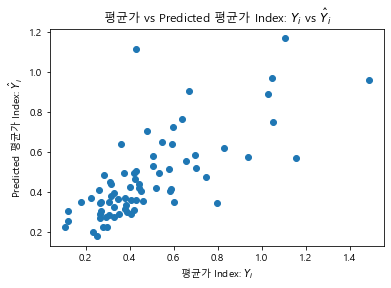

In [110]:
#원래 값과 예측 값이 일치하면 직선에 가깝게 분포가 되는데 결과는 그리 만족스럽지 않은 것 같습니다. 

%matplotlib inline

y_pred = model.predict(X_valid_t, batch_size=32)
plt.scatter(y_valid, y_pred)
plt.rc('xtick', labelsize=5)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=5)  # y축 눈금 폰트 크기
plt.xlabel("평균가 Index: $Y_i$")
plt.ylabel("Predicted 평균가 Index: $\hat{Y}_i$")
plt.title("평균가 vs Predicted 평균가 Index: $Y_i$ vs $\hat{Y}_i$")

In [111]:
y_valid_shift = np.roll(y_valid, 1)
y_valid_shift[0] = None

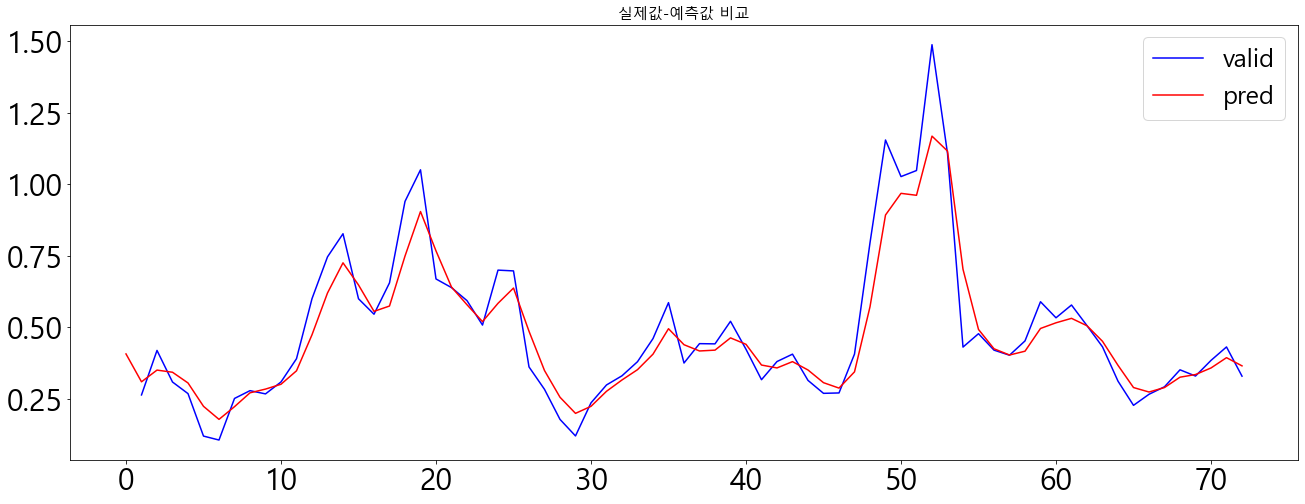

In [113]:
plt.figure(figsize=(22,8))
plt.plot(y_valid_shift, 'b')
plt.plot(y_pred, 'r')
plt.rc('xtick', labelsize=30)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=30)  # y축 눈금 폰트 크기
plt.legend(['valid', 'pred'], fontsize=25)
plt.title('실제값-예측값 비교', fontsize=15)
plt.show()